# email spam classifier project

#  Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud

# Load and Explore the Dataset

In [2]:
df = pd.read_csv("emails.csv")
df

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [3]:
df.info()   # Summary of columns & datatypes
df.shape    # (rows, columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


(5728, 2)

In [4]:
df.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# Data Cleaning

In [5]:
df.rename(columns={'text': 'email', 'spam': 'label'}, inplace=True)
df['label'] = df['label'].astype(int)
print(df.head(10))

                                               email  label
0  Subject: naturally irresistible your corporate...      1
1  Subject: the stock trading gunslinger  fanny i...      1
2  Subject: unbelievable new homes made easy  im ...      1
3  Subject: 4 color printing special  request add...      1
4  Subject: do not have money , get software cds ...      1
5  Subject: great nnews  hello , welcome to medzo...      1
6  Subject: here ' s a hot play in motion  homela...      1
7  Subject: save your money buy getting this thin...      1
8  Subject: undeliverable : home based business f...      1
9  Subject: save your money buy getting this thin...      1


# Visualize the data distribution

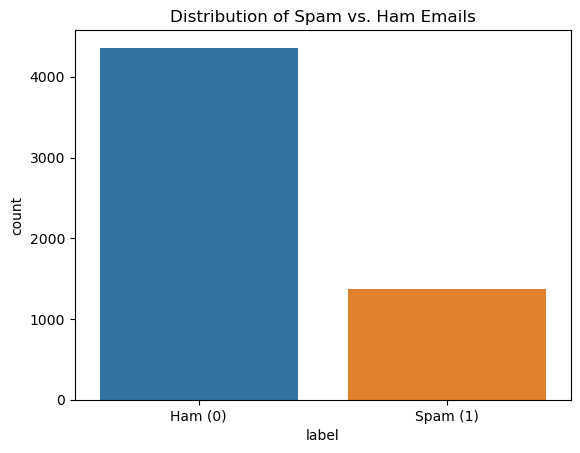

In [6]:
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs. Ham Emails')
plt.xticks(ticks=[0, 1], labels=['Ham (0)', 'Spam (1)'])
plt.show()

# Visualize most common words in spam and ham emails using a WordCloud

In [7]:
spam_words = ' '.join(list(df[df['label']==1]['email']))
ham_words = ' '.join(list(df[df['label']==0]['email']))

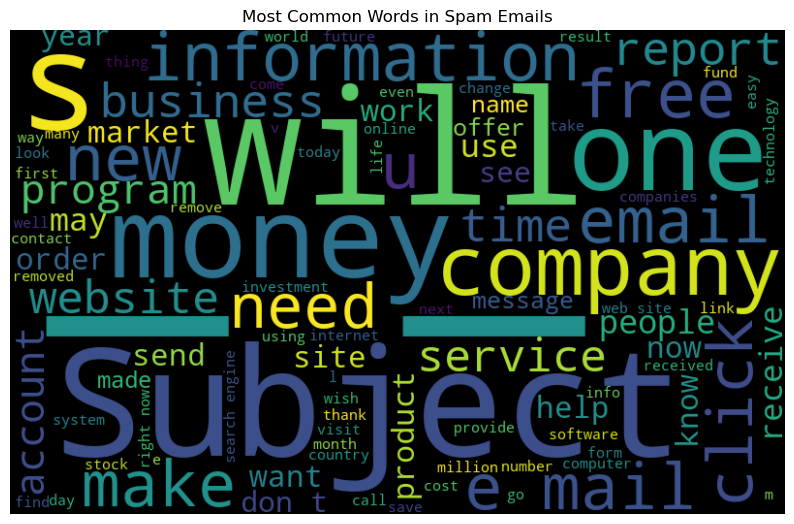

In [8]:
spam_wordcloud = WordCloud(width=800, height=500, background_color='black', max_words=100).generate(spam_words)
plt.figure(figsize=(10, 8))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Spam Emails')
plt.axis('off')
plt.show()

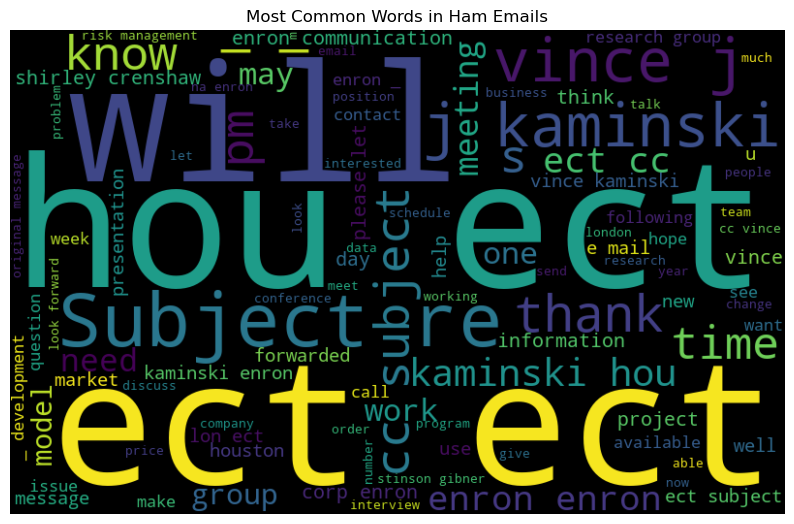

In [9]:
ham_wordcloud = WordCloud(width=800, height=500, background_color='black', max_words=100).generate(ham_words)
plt.figure(figsize=(10, 8))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Ham Emails')
plt.axis('off')
plt.show()

Text Preprocessing Function

In [10]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join the tokens back into a single string
    return ' '.join(filtered_tokens)

Apply preprocessing to the email column

In [11]:
df['processed_email'] = df['email'].apply(preprocess_text)
print("\nSample of processed data:")
print(df[['email', 'processed_email']].head())
df


Sample of processed data:
                                               email  \
0  Subject: naturally irresistible your corporate...   
1  Subject: the stock trading gunslinger  fanny i...   
2  Subject: unbelievable new homes made easy  im ...   
3  Subject: 4 color printing special  request add...   
4  Subject: do not have money , get software cds ...   

                                     processed_email  
0  subject naturally irresistible corporate ident...  
1  subject stock trading gunslinger fanny merrill...  
2  subject unbelievable new homes made easy im wa...  
3  subject color printing special request additio...  
4  subject money get software cds software compat...  


,email,label,processed_email
0,Subject: naturally irresistible your corporate...,1,subject naturally irresistible corporate ident...
1,Subject: the stock trading gunslinger fanny i...,1,subject stock trading gunslinger fanny merrill...
2,Subject: unbelievable new homes made easy im ...,1,subject unbelievable new homes made easy im wa...
3,Subject: 4 color printing special request add...,1,subject color printing special request additio...
4,"Subject: do not have money , get software cds ...",1,subject money get software cds software compat...
...,...,...,...
5723,Subject: re : research and development charges...,0,subject research development charges gpg forwa...
5724,"Subject: re : receipts from visit jim , than...",0,subject receipts visit jim thanks invitation v...
5725,Subject: re : enron case study update wow ! a...,0,subject enron case study update wow day super ...
5726,"Subject: re : interest david , please , call...",0,subject interest david please call shirley cre...


# Split the data into training and testing sets

In [12]:
X = df['processed_email']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set size: {len(X_train)} emails")
print(f"Testing set size: {len(X_test)} emails")


Training set size: 4582 emails
Testing set size: 1146 emails


In [13]:
# Feature Extraction using TF-IDF Vectorizer
# TF-IDF converts text into a numerical matrix where each cell represents
# the importance of a word in a document relative to the entire corpus.
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [14]:
# Train the Multinomial Naive Bayes model
# This algorithm is well-suited for text classification with discrete features (like word counts or TF-IDF scores).
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [15]:
# Make predictions on the test set
predictions = model.predict(X_test_vectorized)

# Evaluate the model

In [16]:
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print(f"Precision: {precision_score(y_test, predictions):.4f}")
print(f"Recall: {recall_score(y_test, predictions):.4f}")
print(f"F1 Score: {f1_score(y_test, predictions):.4f}")


Model Evaluation:
Accuracy: 0.8857
Precision: 1.0000
Recall: 0.5483
F1 Score: 0.7082


# Display a detailed classification report

In [17]:
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['Ham', 'Spam']))


Classification Report:
              precision    recall  f1-score   support

         Ham       0.87      1.00      0.93       856
        Spam       1.00      0.55      0.71       290

    accuracy                           0.89      1146
   macro avg       0.93      0.77      0.82      1146
weighted avg       0.90      0.89      0.87      1146



# Plot a confusion matrix

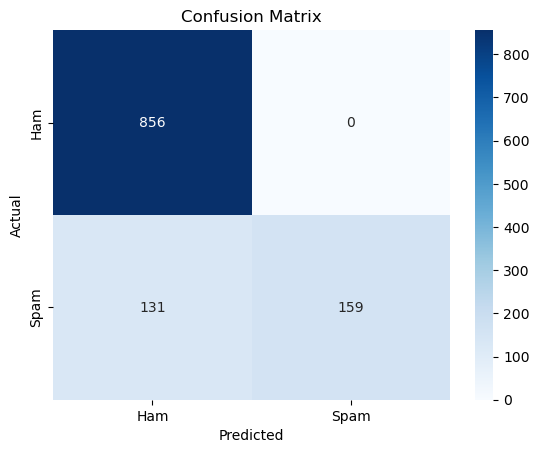

In [18]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Example of using the trained model to classify a new email

In [19]:
def classify_email(email_text):
    processed_email = preprocess_text(email_text)
    vectorized_email = vectorizer.transform([processed_email])
    prediction = model.predict(vectorized_email)[0]
    return "Spam" if prediction == 1 else "Ham"

1st example

In [20]:
new_email_spam = "Get a free lottery ticket! You've been selected to win a million dollars. Click the link now!"
print(f"\nEmail: '{new_email_spam}'\nClassification: {classify_email(new_email_spam)}")


Email: 'Get a free lottery ticket! You've been selected to win a million dollars. Click the link now!'
Classification: Spam


2nd Example

In [21]:
new_email_ham = "Hello team, the project deadline has been extended. The new deadline is next Friday."
print(f"\nEmail: '{new_email_ham}'\nClassification: {classify_email(new_email_ham)}")


Email: 'Hello team, the project deadline has been extended. The new deadline is next Friday.'
Classification: Ham
